<a href="https://colab.research.google.com/github/bilzard/JQuants-news/blob/main/003_time_series_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# はじめに

このnotebook では古典的な時系列モデルであるARIMA(AutoRegressive Integrated Moveng Average)モデルを使って特定の銘柄の株価の時系列を予測します。

In [1]:
%%HTML
<style>
    div#notebook-container    { width: 100%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>

In [7]:
# Google Colab環境ではGoogle Driveをマウントしてアクセスできるようにします。
import sys

if 'google.colab' in sys.modules:
    # Google Drive をマウントします
    from google.colab import drive
    mount_dir = "/content/drive"
    drive.mount(mount_dir)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
# ライブラリのバージョンを調整します
!pip install --no-cache-dir joblib==1.0.1 numpy==1.19.5 pandas==1.1.5 scikit-learn==0.20.3 scipy==1.2.1 seaborn==0.9.0

In [9]:
import io
import os
import sys
import zipfile

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.auto import tqdm
from scipy import stats
from IPython.core.magic import register_cell_magic
import statsmodels.api as sm

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


作業ディレクトリを指定します。自分の環境に合わせて適宜設定してください。

In [10]:
PROJECT_DIR = f'{mount_dir}/MyDrive/JPX_competition/sub001'

In [11]:
# インポート時にエラーが出た場合は、以下のmodule_dirをbacktest.pyを配置したディレクトリに変更してください。
import sys
if 'google.colab' in sys.modules:
  # Backtestを配置したディレクトリへのフルパスを指定します
  module_dir = f"{mount_dir}/MyDrive/JPX_competition/Chapter03/backtest"
else:
  # Backtestを配置したディレクトリへのフルパスを指定します
  module_dir = "/notebook/Chapter03/backtest" 
sys.path.append(module_dir)

from backtest import Backtest

In [12]:
# 表示用の設定を変更します
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100
pd.options.display.width = 120

In [13]:
# データセットを配置したディレクトリのパスを設定
if 'google.colab' in sys.modules:
    dataset_dir = f"{mount_dir}/MyDrive/JPX_competition/data_dir_comp2"
else:
    dataset_dir = "/notebook/data_dir_comp2"

In [14]:
# 入力パラメーターを設定します。ランタイム環境での実行時と同一フォーマットにします
inputs = {
    "stock_list": f"{dataset_dir}/stock_list.csv.gz",
    "stock_price": f"{dataset_dir}/stock_price.csv.gz",
}

In [15]:
# 投資対象日付を指定します
start_dt = pd.Timestamp("2020-01-01")

In [16]:
if "purchase_date" in inputs.keys():
    # ランタイム環境では指定された投資対象日付を使用します
    # purchase_dateを読み込み
    df_purchase_date = pd.read_csv(inputs["purchase_date"])
    # purchase_dateの最も古い日付を投資対象日付として使用します
    start_dt = pd.Timestamp(df_purchase_date.sort_values("Purchase Date").iloc[0, 0])

In [17]:
# 銘柄情報読み込み
df_stock_list = pd.read_csv(inputs["stock_list"])
# 問題2のユニバース (投資対象の条件を満たす銘柄群) 取得
codes = df_stock_list.loc[
    df_stock_list.loc[:, "universe_comp2"] == True, "Local Code"
].unique()

In [18]:
# 価格情報読み込み、インデックス作成
df_price = pd.read_csv(inputs["stock_price"]).set_index("EndOfDayQuote Date")
# 日付型に変換
df_price.index = pd.to_datetime(df_price.index, format="%Y-%m-%d")

In [19]:
# 投資対象日の前週金曜日時点で予測を出力するため、予測出力用の日付を設定します。
pred_start_dt = pd.Timestamp(start_dt) - pd.Timedelta("3D")
# 特徴量の生成に必要な日数をバッファとして設定
n = 30
# データ絞り込み日付設定
data_start_dt = pred_start_dt - pd.offsets.BDay(n)
# 日付で絞り込み
filter_date = df_price.index >= data_start_dt
# 銘柄をユニバースで絞り込み
filter_universe = df_price.loc[:, "Local Code"].isin(codes)
# 絞り込み実施
df_price = df_price.loc[filter_date & filter_universe]

直感的に理解しやすい日付 x 銘柄のテーブルを作ります。

In [20]:
df_per_instruments = pd.pivot_table(df_price, values=['EndOfDayQuote Close'], columns=['Local Code'], index='EndOfDayQuote Date', aggfunc='mean')

扱いにくいmulti index をバラします

In [21]:
df_per_instruments.columns = df_per_instruments.columns.droplevel(level=0)

# 前処理

## 異常値の除外

なぜか 2020-10-01 のデータがすべてゼロになっているので、このレコードを除外します。（おそらくランタイム環境でも外れ値を除外する処理が必要になる）

In [22]:
# 外れ値（終値が1未満）を前方補完
filter_outlier = df_per_instruments.iloc[:, 0] < 1
df_per_instruments.loc[filter_outlier] = np.nan

欠損値を可視化します。さきほど除外した日付が欠損しているのに加え、過去の株価が存在しない銘柄がいくつかあるのがわかります。おそらく新規に売買を開始した銘柄でしょう。

値の補完はあとでまとめて行うので、とりあえずこのままにしておきます。

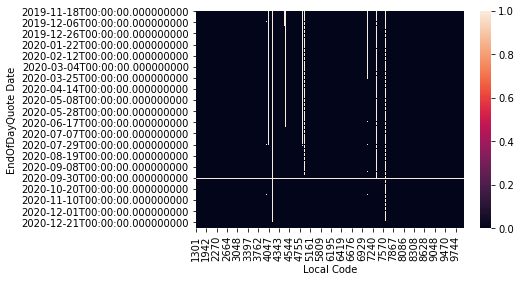

In [23]:
sns.heatmap(df_per_instruments.isna())

 ## 休日の株価データの補完

ARIMAモデルで予測をするときは、歯抜けの日付があるとモデルの学習や予測ができないため、データが存在しない休日のデータを外挿します。
あとでリターンを計算するときに後方補完するので、ここではNaNを挿入しておきます。

In [24]:
idx = pd.date_range('2019-11-18', '2020-12-30')
df_per_instruments = df_per_instruments.reindex(idx)

欠損値を可視化します。隠れていた歯抜けのデータが可視化されました。

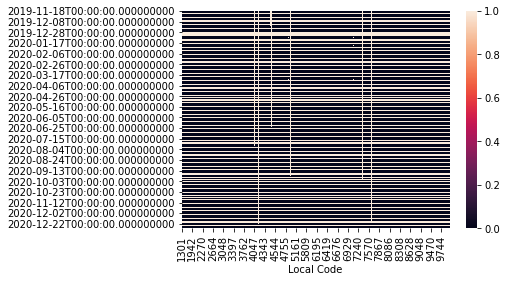

In [25]:
sns.heatmap(df_per_instruments.isna())

## 特徴量の作成

特徴量として直近1日のリターン（株価の変化率）を選びます。
ここでは一日のリターンを前日の終値〜当日の終値までの変化率と定義します。

欠損値は後方補完します。

In [299]:
df_return = df_per_instruments.bfill().pct_change(1).fillna(0)

assert df_return.isna().sum().sum() == 0

あとでSARPEレシオを計算するために、マーケットのリターンを求めます。ここでは全銘柄のリターンの中央値をマーケットのリターンとします。

In [300]:
df_universe = df_return.median(axis=1)

各銘柄のリターンからマーケットのリターンを引いた、マーケット調整済みリターンを求めます。

In [301]:
df_return_mka = df_return.apply(lambda x: x - df_universe)

無限大は扱いにくいので nan に置換します

In [302]:
df_return.replace([np.inf, -np.inf], np.nan, inplace=True)
df_return_mka.replace([np.inf, -np.inf], np.nan, inplace=True)

2020年3月のデータはコロナ禍による影響が含まれていると考えられるため、全区間で平均を計算すると、直近の状況を正しく反映していない可能性があります。コロナ禍の影響が落ち着いてきた4月以降のデータのみでフィルタリングします。

In [303]:
# 2020年 4 月以降に限定
filter_date = df_return_mka.index.to_series().between('2020-04-01', '2021-01-01')

リターンが大きい銘柄は、ボラティリティ（標準偏差）も大きい傾向にあります。
ポートフォリオを組むさいは、ボラが大きすぎる銘柄はリスクも大きいので、何らかの指標でで評価できると便利です。
ここではSHARPEレシオを採用します。

In [304]:
df_ = pd.concat([
    df_return[filter_date].replace([np.inf, -np.inf], np.nan).mean(),
    df_return[filter_date].replace([np.inf, -np.inf], np.nan).std(),
    df_return_mka[filter_date].replace([np.inf, -np.inf], np.nan).mean(),
    df_return_mka[filter_date].replace([np.inf, -np.inf], np.nan).std(),
], axis=1)
df_.columns = ['return_7_mean', 'return_7_std', 'mka_return_7_mean', 'mka_return_7_std']
df_['SHARPE'] = df_['mka_return_7_mean'] / df_['mka_return_7_std']

In [305]:
df_.sort_values('mka_return_7_mean', ascending=False, inplace=True)

このあと個別の銘柄のテクニカル分析を行いますが、選択した銘柄情報を結合したデータをつくっておきます。

In [306]:
df_instrument = pd.merge(
    df_.replace([np.inf, -np.inf], np.nan).sort_values('return_7_mean', ascending=False),
    df_stock_list.set_index('Local Code')[['Name (English)', '33 Sector(name)']],
    right_index=True,
    left_index=True,
    how='left'
)

# 個別銘柄の時系列の分析

週次リターンの期待値が大きい上位50銘柄をプロットします。

リターンの期待値が大きい銘柄はリスクが大きい銘柄でもありますが、テクニカル分析で値動きを予測できれば大きなリターンが見込めます。
今回は週次リターンの高い銘柄をピックアップして値動きの予測を行います。

ほかには、より安全をとって、SHARPEレシオの大きい銘柄を選択する方針もあります。

In [307]:
assets =df_instrument.sort_values('return_7_mean', ascending=False).head(20).index.values

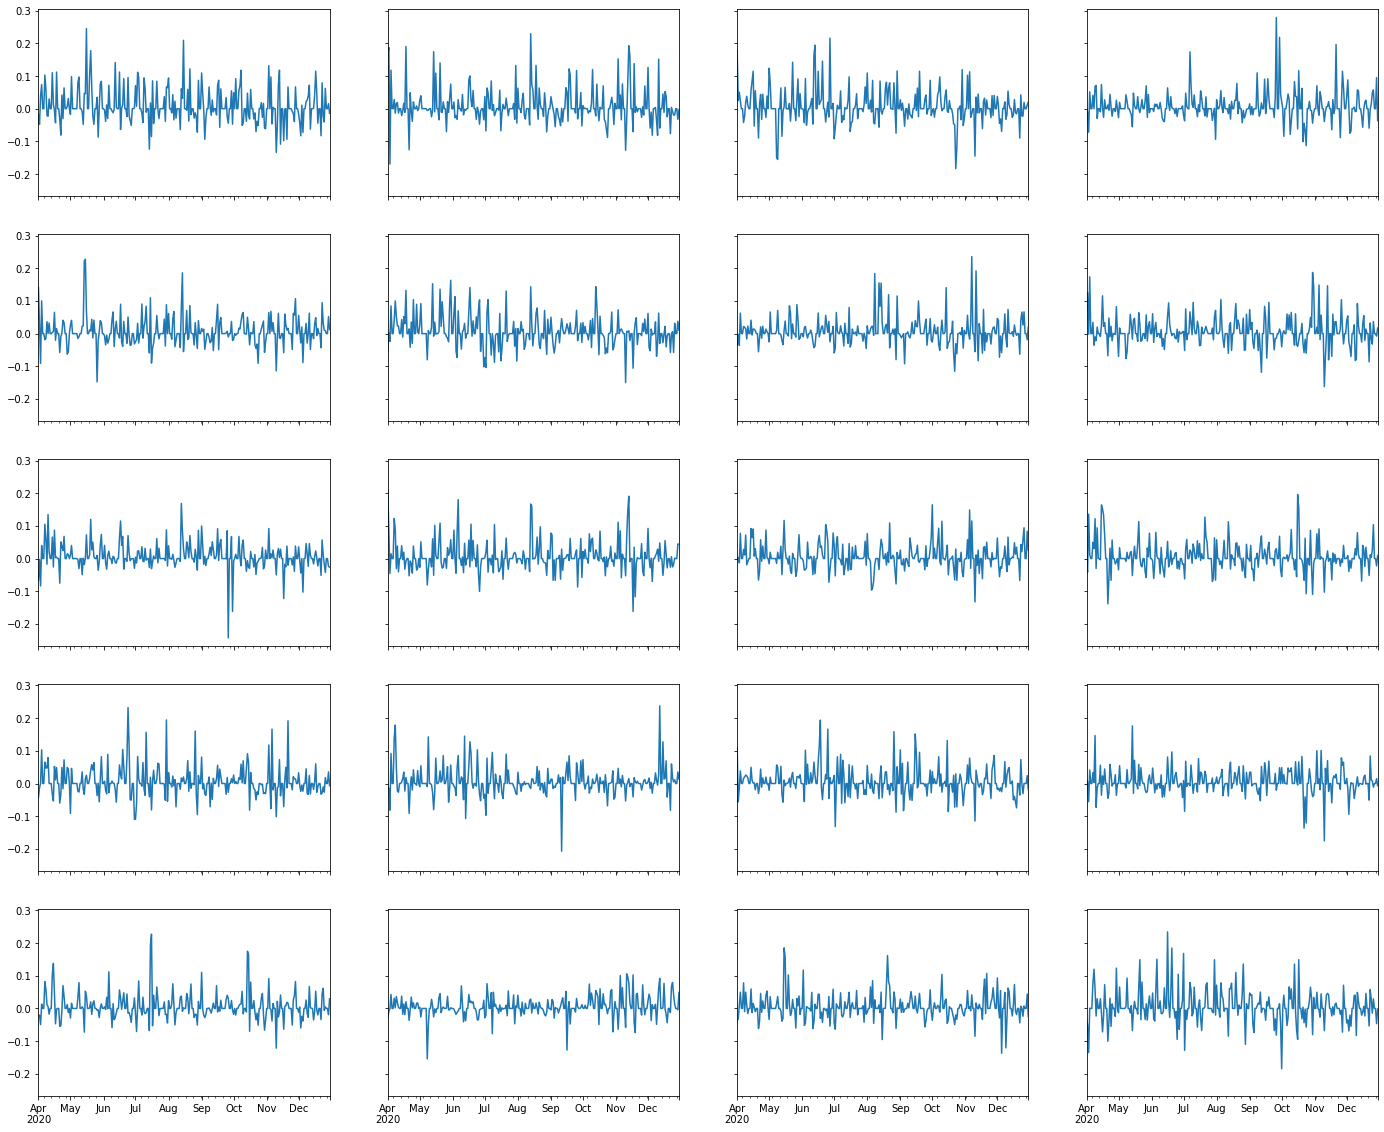

In [308]:
cols = 4
rows = (len(assets) - 1) // cols + 1
fig, axes = plt.subplots(rows, cols, figsize=(6*cols, 4*rows), sharex=True, sharey=True)
axes = axes.ravel()

for i, asset in enumerate(assets):
  df_return.loc[filter_date, asset].plot(ax=axes[i])

2020年4月〜2020年12月の期間において、リターンの期待値が最も大きい銘柄について、テクニカル分析を試みます。

In [309]:
df = df_return.loc[:,assets[0]]

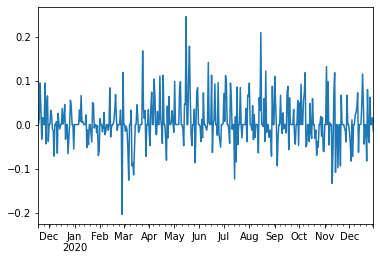

In [310]:
df.plot()

ちなみに BASE Inc. という銘柄です。

ネットショップ作成サービスやオンライン決済のサービスを提供している企業のようです。
https://binc.jp/

In [311]:
df_instrument.loc[assets[0]]

return_7_mean                          0.0093919
return_7_std                           0.0530135
mka_return_7_mean                      0.0089877
mka_return_7_std                       0.0523078
SHARPE                                  0.171823
Name (English)                         BASE,Inc.
33 Sector(name)      Information & Communication
Name: 4477, dtype: object

まず、自己相関をみます。直近6日くらいのデータと相関があります。

みかけの相関を除外した編自己相関をみると、2日前〜6日前との相関はみかけの相関だったことがわかります。
また、1+7Nのところで偏自己相関が大きくなっています。

この理由はわかりませんが、週次の値動きの影響を表しているのかもしれません。

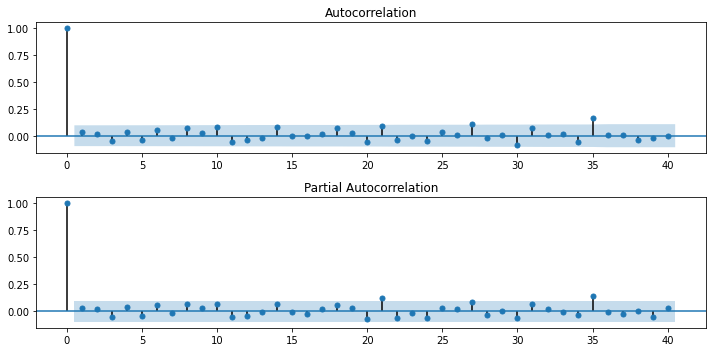

In [312]:
fig,ax= plt.subplots(2,1, figsize=(10,5))
fig=sm.tsa.graphics.plot_acf(df, lags=40, ax=ax[0])
fig=sm.tsa.graphics.plot_pacf(df, lags=40, ax=ax[1])
plt.tight_layout()

分析対象の時系列系列の定常性を検査するために、ADFで検定します。

ADFでは「対象の時系列は単位根（1回差分をとると定常な時系列になる）をもつ」という帰無仮説を前提として検定するので、p値が小さいほど定常な時系列（単位根をもたない）と判断できます。

今回の場合だと6.0%なので、差分はとらなくてもよさそうと判断します。

In [313]:
res = sm.tsa.adfuller(df, regression='ct')
print(f'p-value{res[1]}')

p-value0.0


ついでに週次の差分をとった系列についてもADFで検定します。
こちらのほうがp値が小さく、定常な時系列と判断できます。
週次の季節変動を考慮するとうまくフィッティングできる可能性があります。

In [314]:
res = sm.tsa.adfuller(df.diff(7).dropna(), regression='ct')
print(f'p-value{res[1]}')

p-value7.30049784637706e-11


参考までに、週次の差分をとった系列の時系列とコレログラムを可視化しておきます。

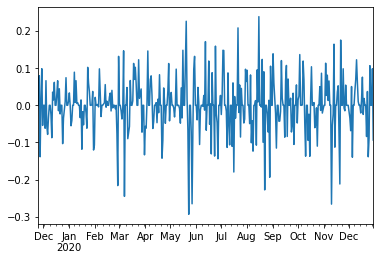

In [315]:
df.diff(7).dropna().plot()

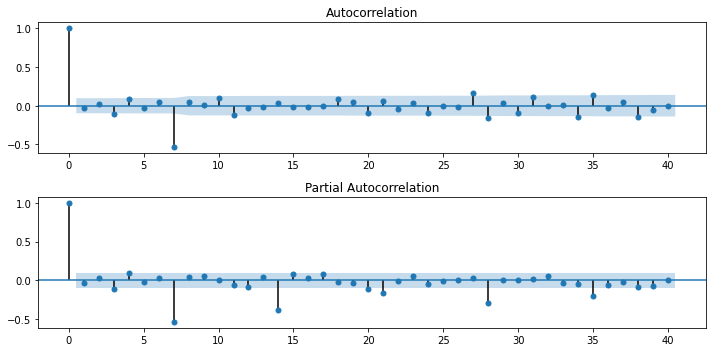

In [316]:
fig,ax= plt.subplots(2,1, figsize=(10,5))
fig=sm.tsa.graphics.plot_acf(df.diff(7).dropna(), lags=40, ax=ax[0])
fig=sm.tsa.graphics.plot_pacf(df.diff(7).dropna(), lags=40, ax=ax[1])
plt.tight_layout()

# モデルの学習と予測

ARIMAモデルに季節変動と外的変動の効果を組み込んだ SARIMAXモデル を使って将来のリターンを予測します。

モデルのコードは以下のkaggleのディスカッションを参考にしました。
https://www.kaggle.com/poiupoiu/how-to-use-sarimax

In [317]:
from sklearn.metrics import mean_squared_error

def train_pred(tr_start, tr_end, te_start, te_end):
  train_df = df[tr_start:tr_end].dropna()
  test_df = df[te_start:te_end].dropna()

  ma, ar = resDiff['aic_min_order']
  arima = sm.tsa.statespace.SARIMAX(train_df, order=(8, 0, 0),seasonal_order=(0, 0, 0, 7),
                              enforce_stationarity=False, enforce_invertibility=False, trend='c').fit()

  pred = arima.predict(tr_end, te_end)[1:]
  error = mean_squared_error(test_df, pred)
  print(f'ARIMA model MSE:{error:5.5f}')

  fig, axes = plt.subplots(1, 2, figsize=(6 * 2, 4))
  pd.DataFrame({'train': train_df.tail(100)}).plot(ax=axes[0])
  pd.DataFrame({'test': test_df, 'pred': pred}).plot(ax=axes[0])
  pd.DataFrame({'test': test_df, 'pred': pred}).cumsum().plot(ax=axes[1])

  cumsum_df = pd.DataFrame({'test': test_df, 'pred': pred}).cumsum()

  return error, pred

予測対象期間は2020/08/11 - 2020/12/28 までの20ラウンドで、学習に使うデータは予測対象期間の101日前〜前日までとしました。

In [318]:
dates = pd.date_range(end='2020/12/22', periods=20, freq='7d')

for i, round_start in enumerate(dates):
  tr_start = (round_start + timedelta(days=-101)).strftime('%Y-%m-%d')
  tr_end = (round_start + timedelta(days=-1)).strftime('%Y-%m-%d')
  te_start = round_start.strftime("%Y-%m-%d")
  te_end = (round_start + timedelta(days=6)).strftime("%Y-%m-%d")
  print(f'round: {i}: {te_start} - {te_end} (train: {tr_start} - {tr_end})')

round: 0: 2020-08-11 - 2020-08-17 (train: 2020-05-02 - 2020-08-10)
round: 1: 2020-08-18 - 2020-08-24 (train: 2020-05-09 - 2020-08-17)
round: 2: 2020-08-25 - 2020-08-31 (train: 2020-05-16 - 2020-08-24)
round: 3: 2020-09-01 - 2020-09-07 (train: 2020-05-23 - 2020-08-31)
round: 4: 2020-09-08 - 2020-09-14 (train: 2020-05-30 - 2020-09-07)
round: 5: 2020-09-15 - 2020-09-21 (train: 2020-06-06 - 2020-09-14)
round: 6: 2020-09-22 - 2020-09-28 (train: 2020-06-13 - 2020-09-21)
round: 7: 2020-09-29 - 2020-10-05 (train: 2020-06-20 - 2020-09-28)
round: 8: 2020-10-06 - 2020-10-12 (train: 2020-06-27 - 2020-10-05)
round: 9: 2020-10-13 - 2020-10-19 (train: 2020-07-04 - 2020-10-12)
round: 10: 2020-10-20 - 2020-10-26 (train: 2020-07-11 - 2020-10-19)
round: 11: 2020-10-27 - 2020-11-02 (train: 2020-07-18 - 2020-10-26)
round: 12: 2020-11-03 - 2020-11-09 (train: 2020-07-25 - 2020-11-02)
round: 13: 2020-11-10 - 2020-11-16 (train: 2020-08-01 - 2020-11-09)
round: 14: 2020-11-17 - 2020-11-23 (train: 2020-08-08 - 20

各ラウンドの予測と学習結果を可視化します。
左側にリターンの時系列、右側にリターンを積分した週次リターンを示しています。

ARIMA model MSE:0.00599
ARIMA model MSE:0.00226
ARIMA model MSE:0.00239
ARIMA model MSE:0.00379
ARIMA model MSE:0.00121
ARIMA model MSE:0.00205
ARIMA model MSE:0.00113
ARIMA model MSE:0.00199
ARIMA model MSE:0.00468
ARIMA model MSE:0.00151
ARIMA model MSE:0.00245
ARIMA model MSE:0.00195
ARIMA model MSE:0.00420
ARIMA model MSE:0.00706
ARIMA model MSE:0.00394
ARIMA model MSE:0.00136
ARIMA model MSE:0.00204


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA model MSE:0.00182
ARIMA model MSE:0.00289
ARIMA model MSE:0.00264


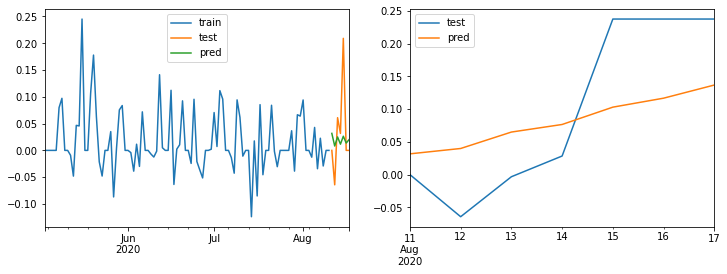

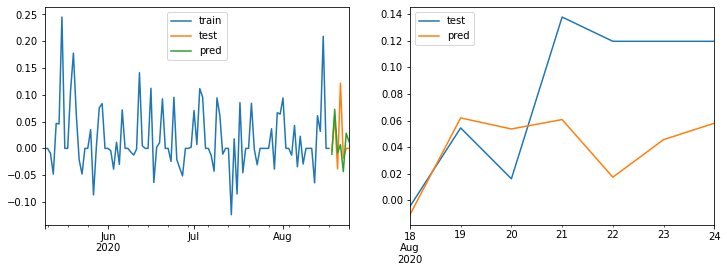

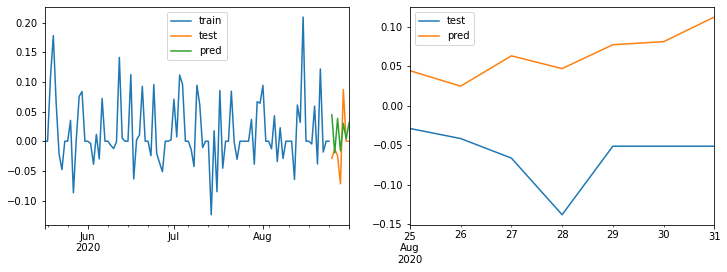

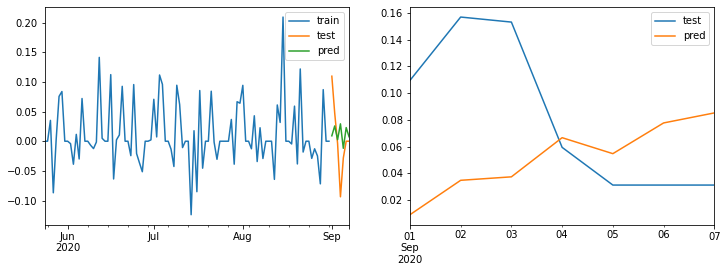

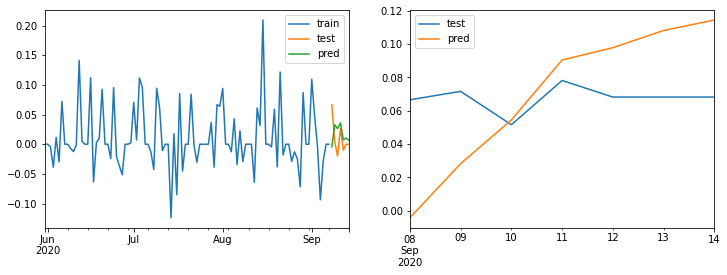

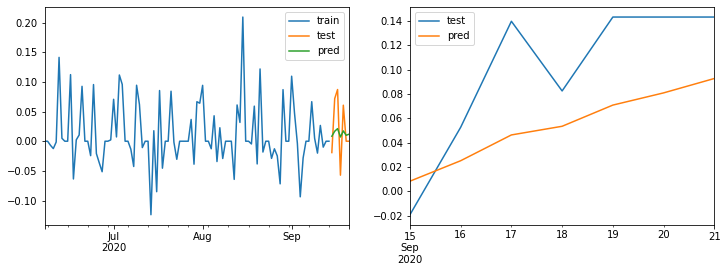

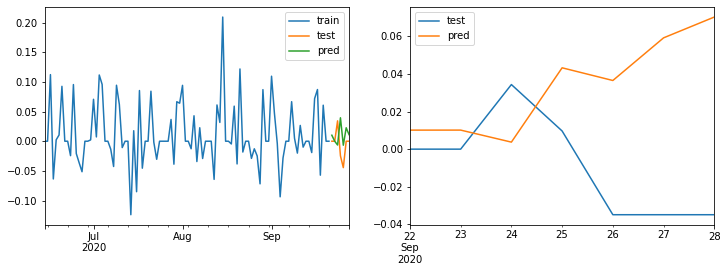

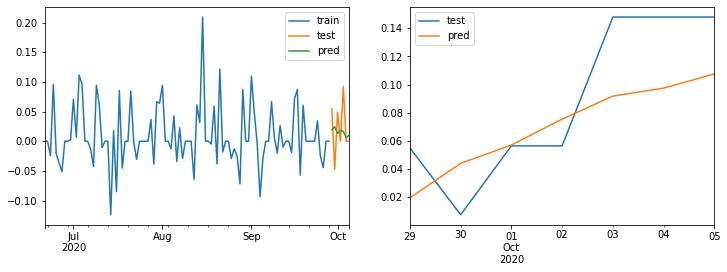

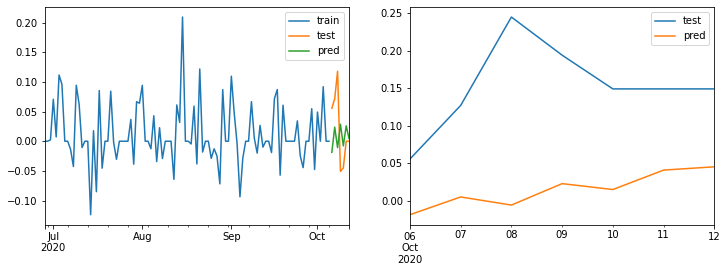

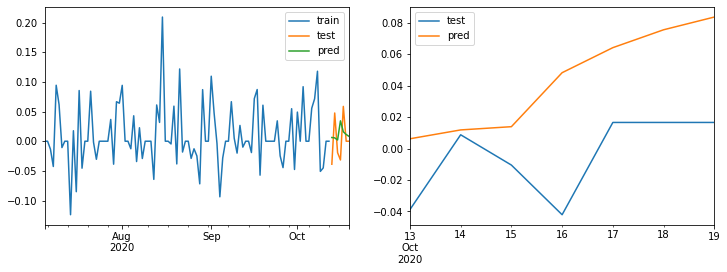

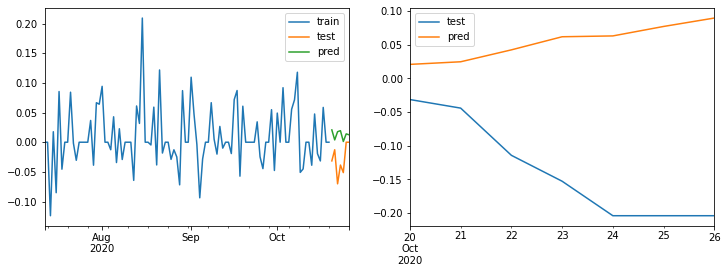

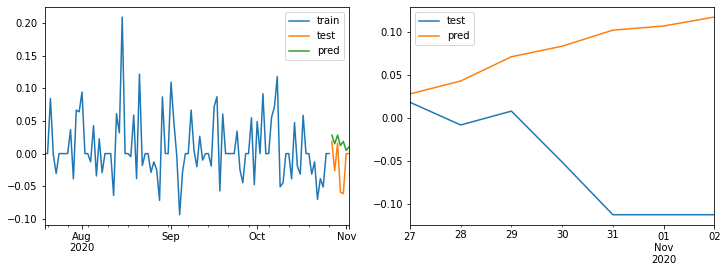

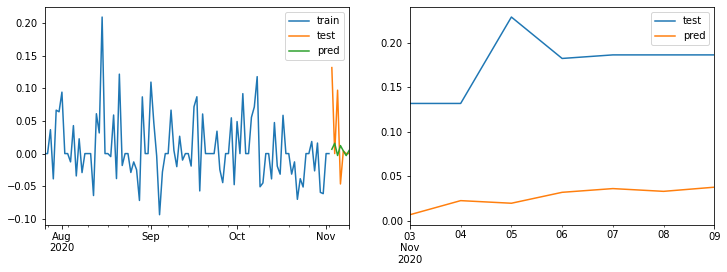

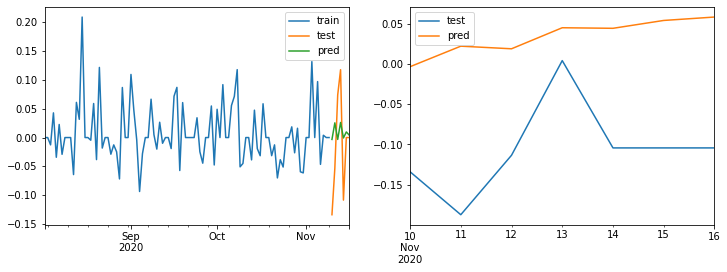

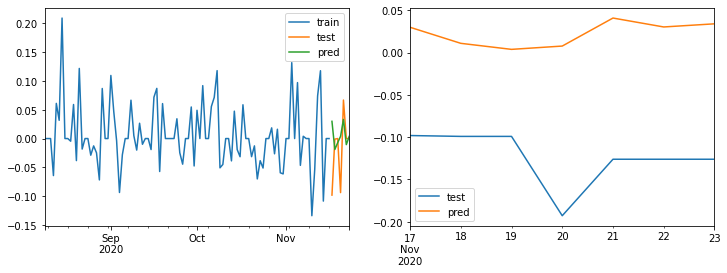

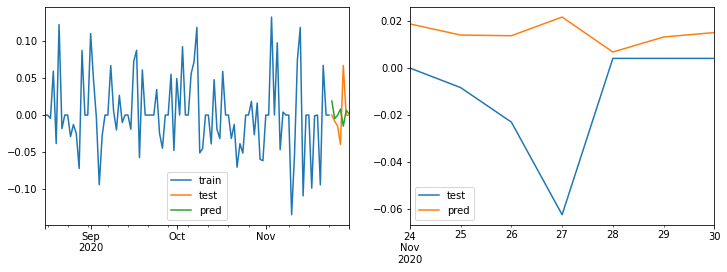

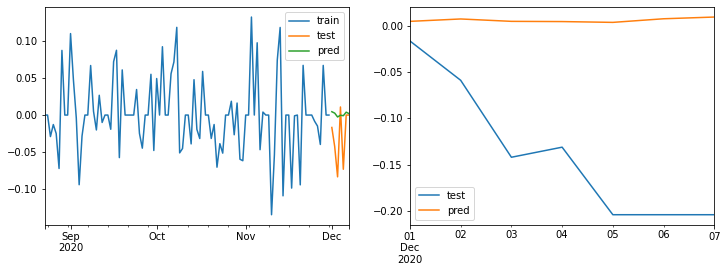

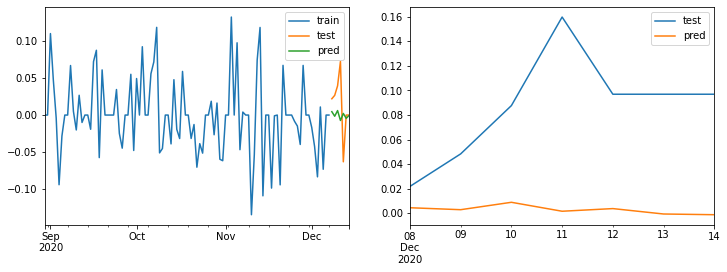

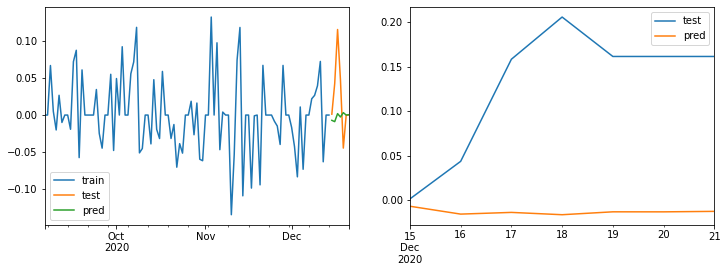

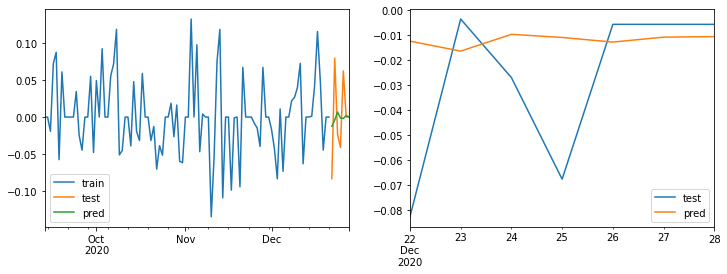

In [322]:
from datetime import timedelta

dates = pd.date_range(end='2020/12/22', periods=20, freq='7d')
pred_return = []
actual_return = []

for i, round_start in enumerate(dates):
  tr_start = (round_start + timedelta(days=-101)).strftime('%Y-%m-%d')
  tr_end = (round_start + timedelta(days=-1)).strftime('%Y-%m-%d')
  te_start = round_start.strftime('%Y-%m-%d')
  te_end = (round_start + timedelta(days=6)).strftime('%Y-%m-%d')

  test_df = df[te_start:te_end].dropna()

  error, pred = train_pred(tr_start, tr_end, te_start, te_end)
  pred_return.append(pred.cumsum().tail(1).values[0])
  actual_return.append(test_df.cumsum().tail(1).values[0])

各ラウンドで得られたリターンの分布をみます。予測値のほうが実際の値よりも分散が小さくなっています。

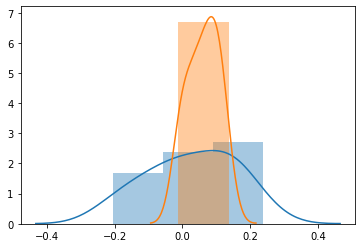

In [329]:
sns.distplot(actual_return, label='actual 7 day return')
sns.distplot(pred_return, label='predicted 7 day return')

各ラウンドの週次リターンの予測値と実際の値を可視化します。

前半の10ラウンドは株価の上昇傾向を概ねとらえられていますが、後半の10ラウンドで起こっている急落を正しく捉えられていません。

株価が上昇傾向のときはパフォーマンスが良いが、下降あるいは乱高下する局面ではパフォーマンスが悪くなる可能性があります。

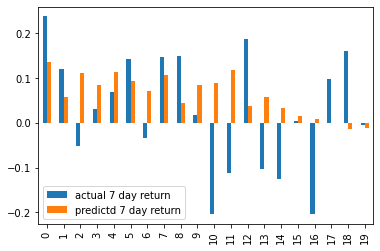

In [330]:
pd.DataFrame({'actual 7 day return': actual_return, 'predictd 7 day return': pred_return}).plot.bar()

週次リターンの予測値を最大値で正規化して、0から1の範囲にした自信度を算出し、実際のリターンと掛け合わせて平均をとることで、ラウンドごとのリターンの期待値を求めます。

なお、自信度が0だとこの銘柄を全く購入しないことに相当し、自信度が1だと予算をすべて使ってこの銘柄を購入することに相当します。

結果をみると、リターンの期待値が1.5%に対して、標準偏差が7.6%とかなりボラが大きいです。

expected: 0.01546, risk: 0.07697


Text(0.5, 1.0, 'performance')

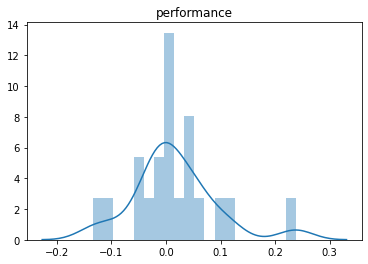

In [348]:
future_return = [x * max(y, 0) for x, y in zip(actual_return, pred_return / np.max(pred_return))]
expected = np.mean(future_return)
risk = np.std(future_return)
print(f'expected: {expected:5.5f}, risk: {risk:5.5f}')

ax = sns.distplot(future_return, bins=20)
ax.set_title('performance')

TODO: よりナイーブな購入戦略との比較。

1. 直近1週間の週次リターンを次の1週間のリターンの予測値とする（後方補完）
2. 直近N日の平均値を次の1週間のリターンの予測値とする（平均値）
3. 20日平均と比べて直近1週間のリターンが大きければ高い自信度を与える（マーケット追従）
4. 20日平均と比べて直近1週間のリターンが小さければ高い自信度を与える（逆張り）



# まとめ

本notebookでは個別銘柄の値動きを時系列モデルで予測しました。
